# TILD + FEP example - quasi-harmonic to fully interacting - Lammps

### TILD - Thermodynamic Integration using Langevin Dynamics
### FEP - Free Energy Perturbation

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt

from pyiron import Project
import pyiron_contrib

In [2]:
# define project

pr = Project('tild_example')
pr.remove_jobs_silently(recursive=True)

In [3]:
pr.get_repository_status()

,Module,Git head
0,pyiron,ef5db249200057abb0b96e9643c34de72ca6fdcf
1,pyiron_mpie,d90b955fb16fefd70ccab9d69c7c177190c81fd7
2,pyiron_contrib,0b3c052c3e7cd70cf10362057cf3d95670a6fb52
3,pyiron_atomistics,3d85c1cb5d16080dd63ade0dda17dc1564b10e36
4,pyiron_base,576da49c498209c3907b23195339241621249fd8
5,pyiron_continuum,Not a repo


In [4]:
# inputs

# structure
element = 'Al'
crystal_structure = 'fcc'
supercell = 3
potential = '2008--Mendelev-M-I--Al--LAMMPS--ipr1'

# MD specific
a = 4.073603  # this I obtained from calc_md at 300K. 
temperature = 300.
time_step = 1.  # MD timestep
n_steps = 1000  # MD steps
sampling_period = 10  # same as `n_print` from calc_md
thermalization_steps = 200  # number of steps to equilibriate the system for
temperature_damping_timescale = 100.  # same as the one from calc_md 
convergence_steps = 500  # number of steps after which to check for convergence
fe_tol = 1e-3  # convergence criterion 1meV 

# integration specific
n_lambdas = 7
force_constants = None  # for this calculation, we input force constants from phonopy - re-assigned later.
spring_constant = None  # if you do not want to specify the force constants, you can still specify a spring constant.
# in this case, you will obtain the free energy between the atoms behaving as independent non-interacting harmonic 
# oscillators with a single spring constant (i.e., Einstein atoms), and the atoms having full interaction.

# cluster specific
phon_cores = 4
phon_run_time = 1800  # in seconds
tild_cores = 4  # if running on the headnode, use 1! Otherwise, set to n_lambdas
queue = 'cmti'
tild_run_time = 14400  # in seconds

In [5]:
# structures with the expanded lattice

pr_zero = pr.create_group('ionic_relaxation')

zero = pr_zero.create_job(pr.job_type.Lammps, 'zero')
zero.structure = pr.create_ase_bulk(name=element, crystalstructure=crystal_structure, cubic=True).repeat(supercell)
n_atoms = len(zero.structure.positions)
zero.potential = potential
zero.calc_minimize(pressure=0.)
zero.run()

/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/hdfio.py:361: UserWarning: swmr=True only affects read ('r') mode. For swmr write mode, set f.swmr_mode = True after opening the file.
  with h5py.File(self.file_name, mode="a", libver="latest", swmr=True) as h:


The job zero was saved and received the ID: 14607620


In [6]:
# structures with the expanded lattice

bulk = pr_zero.create_job(pr.job_type.Lammps, 'bulk')
bulk.structure = pr.create_ase_bulk(name=element, crystalstructure=crystal_structure, a=a,
                                    cubic=True).repeat(supercell)
bulk.potential = potential
bulk.calc_minimize(pressure=None)  # we keep the volume constant! (because we obtained the lattice constant from MD)
bulk.run()

eq_energy = bulk.output.energy_pot[-1]  # The potential energy of the frozen structure at the input temperature

/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/hdfio.py:361: UserWarning: swmr=True only affects read ('r') mode. For swmr write mode, set f.swmr_mode = True after opening the file.
  with h5py.File(self.file_name, mode="a", libver="latest", swmr=True) as h:


The job bulk was saved and received the ID: 14607621


In [7]:
# generate lambdas (integration_points)

def generate_lambdas(N, bias=0.5):
    """
    A function to generate N points between 0 and 1, with a left, equidistant and right bias.
    bias = 0 makes the points fully left biased. The amount of left bias can be controlled by varying it between 0 and 
        0.49.
    bias = 0.5 keeps the points equidistant.
    bias = 1 makes the points fully right biased. The amount of right bias can be controlled by varying it between 0.51 
        and 1.
    
    """
    factor = bias + 0.5
    lambdas = [0, 1]
    for n in np.arange(N - 2):
        lambdas.append(lambdas[-1] + (lambdas[-1] - lambdas[-2]) / factor)
    lambdas = np.asarray(lambdas)
    lambdas /= lambdas[-1]
    
    return np.around(lambdas, decimals=4)

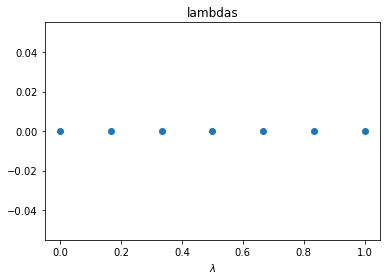

In [8]:
# plot lambdas

# we use equidistant bias in new_generate_lambdas
lambdas = generate_lambdas(n_lambdas, bias=0.5)

plt.title('lambdas')
plt.scatter(lambdas, np.zeros(n_lambdas))
plt.xlabel('$\lambda$')
plt.show()

In [9]:
# setup phonopy jobs

pr_phon = pr.create_group('phonons')

phon_ref_job = pr_phon.create_job(pr.job_type.Lammps, 'phon_ref')
phon_ref_job.structure = bulk.get_structure()
phon_ref_job.potential = potential

phonopy_job = phon_ref_job.create_job(pr.job_type.PhonopyJob,'phonopy_job')
phonopy_job.server.cores = phon_cores
# phonopy_job.server.queue = queue
# phonopy_job.server.run_time = phon_run_time

phonopy_job.run()

/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/hdfio.py:361: UserWarning: swmr=True only affects read ('r') mode. For swmr write mode, set f.swmr_mode = True after opening the file.
  with h5py.File(self.file_name, mode="a", libver="latest", swmr=True) as h:


The job phonopy_job was saved and received the ID: 14607622
The job phon_ref_0 was saved and received the ID: 14607623


/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/hdfio.py:361: UserWarning: swmr=True only affects read ('r') mode. For swmr write mode, set f.swmr_mode = True after opening the file.
  with h5py.File(self.file_name, mode="a", libver="latest", swmr=True) as h:


In [10]:
# load phonopy jobs, in case you ran this on the cluster    

# phon_path = Project('qh_to_interacting_free energy/phonons/')
# phonopy_job = phon_path.load('phonopy_job')

# extract qh free energies
therm_prop = phonopy_job.get_thermal_properties(temperatures=temperature)
A_qh = therm_prop.free_energies[-1]  # A, because this is technically still the Helmholtz free energy

# get force constants
force_constants = phonopy_job.phonopy.force_constants

In [11]:
# # in case you want a calculated guess of the spring constant

# # obtain a spring constant using 0K structure, by displacing a single atom
# # a random spring constant can also be assumed, for example 1 or 5 eV/Ang^2

# spring_folder = pr.create_group('spring_job')

# # clear any existing spring_constant jobs
# spring_folder.remove_jobs_silently(recursive=True)

# spring_job = spring_folder.create_job(pr.job_type.Lammps, 'spring_job')
# spring_job.structure = zero.get_structure()
# spring_job.potential = potential

# deviations = np.linspace(-0.5, 0.5, num=10)
# restoring_forces = np.empty(deviations.shape)

# spring_job.interactive_open()
# for i, d in enumerate(deviations):
#     spring_job.structure.positions[0, 0] = zero.get_structure().positions[0, 0] + d
#     spring_job.calc_static()
#     spring_job.run()
#     restoring_forces[i] = spring_job.interactive_energy_pot_getter()
# spring_job.interactive_close()

# spring_constant = np.polyfit(deviations, restoring_forces, 2)[0]

# print("A spring constant of {} eV/angstrom^2 was found".format(spring_constant))

In [12]:
# run the TILD protocol

pr_tild = pr.create_group('tild_jobs')

tild_ref_job = pr_tild.create_job(pr.job_type.Lammps, 'ref_job')
tild_ref_job.potential = potential
tild_ref_job.structure = bulk.get_structure()
tild_ref_job.save()

tild_job = pr_tild.create_job(pr.job_type.ProtoHarmTILDPar, 'tild_job')
tild_job.input.structure = bulk.get_structure()
tild_job.input.temperature = temperature
tild_job.input.ref_job_full_path = tild_ref_job.path
tild_job.input.spring_constant = spring_constant
tild_job.input.force_constants = force_constants
tild_job.input.n_lambdas = n_lambdas
tild_job.input.sampling_period = sampling_period
tild_job.input.thermalization_steps = thermalization_steps
tild_job.input.custom_lambdas = lambdas
tild_job.input.n_steps = n_steps
tild_job.input.convergence_check_steps = convergence_steps
tild_job.input.fe_tol = 0.001
tild_job.input.eq_energy = eq_energy

# sleep-time, set this only if you're running this on your local PC
tild_job.input.sleep_time = 0.05

# cluster inputs
tild_job.server.cores = tild_cores
# tild_job.server.queue = queue
tild_job.server.run_time = tild_run_time

# run_job
tild_job.run()

The job ref_job was saved and received the ID: 14607624
The job tild_job was saved and received the ID: 14607625
The job tild_job_create_jobs_0 was saved and received the ID: 14607626
The job tild_job_create_jobs_1 was saved and received the ID: 14607627
The job tild_job_create_jobs_2 was saved and received the ID: 14607628
The job tild_job_create_jobs_3 was saved and received the ID: 14607629
The job tild_job_create_jobs_4 was saved and received the ID: 14607630
The job tild_job_create_jobs_5 was saved and received the ID: 14607631
The job tild_job_create_jobs_6 was saved and received the ID: 14607632


/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericPa

[0, 1, 2, 3, 5, 4, 6]
Time elapsed : 4.024688005447388
The job tild_job_create_jobs_0 was saved and received the ID: 14607633
The job tild_job_create_jobs_1 was saved and received the ID: 14607634
The job tild_job_create_jobs_2 was saved and received the ID: 14607635
The job tild_job_create_jobs_3 was saved and received the ID: 14607636
The job tild_job_create_jobs_4 was saved and received the ID: 14607637
The job tild_job_create_jobs_5 was saved and received the ID: 14607638
The job tild_job_create_jobs_6 was saved and received the ID: 14607639


/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:283: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericPa

[0, 1, 2, 3, 4, 5, 6]
Time elapsed : 4.135098457336426
Maximum steps reached


In [13]:
# # if you wat to run the job for more number of steps

# tild_job.input.n_steps = 20000
# tild_job.run(continue_run=True)

In [14]:
# load tild jobs, in case you ran this on the cluster   

# path = Project('tild_example/tild_jobs/')
# tild_job = path.inspect('tild_job')

total_steps = tild_job['output/total_steps']
temperature_mean = tild_job['output/temperature_mean/i_0']
temperature_std = tild_job['output/temperature_std/i_0']
integrands = tild_job['output/integrands/i_0']
integrands_std = tild_job['output/integrands_std/i_0']
integrands_n_samples = (tild_job['output/integrands_n_samples/i_0'])
del_A_tild = tild_job['output/tild_free_energy_mean'][-1]  # A, because this is the Helmholtz free energy
del_A_tild_std = tild_job['output/tild_free_energy_std'][-1]
del_A_tild_se = tild_job['output/tild_free_energy_se'][-1]
del_A_fep = tild_job['output/fep_free_energy_mean'][-1]  # we also get A from the free energy perturbation method
del_A_fep_std = tild_job['output/fep_free_energy_std'][-1]
del_A_fep_se = tild_job['output/fep_free_energy_se'][-1]

In [15]:
# Check temperature of each lambda point

print('mean temperature: {} K'.format(np.mean(temperature_mean)))

mean temperature: 296.3235951187966 K


In [16]:
# Helmholtz free energy between the quasi-harmonic and fully interacting system using TILD and FEP

print('del_A_tild: {} meV/atom'.format(del_A_tild * 1e3 / n_atoms))  # * 1e3 to convert it to meV
print('del_A_fep: {} meV/atom'.format(del_A_fep * 1e3 / n_atoms))

del_A_tild: 3.8145111255106054 meV/atom
del_A_fep: 3.676479073002184 meV/atom


In [17]:
# qh approximated analytical free energy

print('A_qh: {} meV/atom'.format(A_qh * 1e3 / n_atoms))

A_qh: -11.853591158735352 meV/atom


In [19]:
# total free energy of the system at this temperature, including all parts

A_tild = eq_energy + A_qh + del_A_tild
A_fep = eq_energy + A_qh + del_A_fep
print('A_tild: {} eV/atom'.format(A_tild / n_atoms))
print('A_fep: {} eV/atom'.format(A_fep / n_atoms))

A_tild: -3.416992470412391 eV/atom
A_fep: -3.4171305024648997 eV/atom
